# TOB Exchange Example

In this example we implement a very simple top-of-book imbalance. We measure imbalance as the bid pressure
$$i_t = \frac{bq_t}{bq_t + aq_t}$$
Where $bq$ is the bid quantity and $aq$ the ask quantity on the top of the orderbook.

In [1]:
import os 
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

# Import package
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from src.exchange import TOB_Exchange

%load_ext autoreload 
%autoreload 2

In [2]:
base = 'BTC'
quote = 'USDT'
symbol = base + quote

## Import Data

In [3]:
folder_path = 'data_loader/datasets/'

In [4]:
def get_data(files_list):
    df = pd.DataFrame()
    # Use a loop to get all the csv.gz files from the path location in a single Dataframe
    for csv_file in tqdm(files_list):
        file_name = (folder_path + csv_file)
        if file_name[-2:] == "gz":
            df1 = pd.read_csv(file_name, compression='gzip')
            # Concatenate all the dataframes into a single dataframe
            df = pd.concat([df, df1], ignore_index=True)
    return df

In [5]:
# define folder path
files_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'binance' 
    # and f.split('_')[-1] == f'{quote}-{base}.csv.gz'
    and f.split('_')[-1] == f'{base+quote}.csv.gz'
    and f.split('_')[1] == 'quotes']
files_list

['binance_quotes_2023-07-01_BTCUSDT.csv.gz']

In [6]:
binance_data = get_data(files_list)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


In [7]:
binance_data['time'] = pd.to_datetime(binance_data.timestamp, unit='us')
binance_data.set_index('time', inplace=True)

## Open Exchange

In [15]:
# Create new exchange called binance with a average latency of 5000 us and 29% std
binance = TOB_Exchange(latency=[5000, 0.29])
# Were traing one market in this example, so were adding it to the markets
binance.add_market(symbol, base, quote)
# We start with a balance for only BTC 
binance.add_balance(base, 0)
binance.add_balance(quote, 10_000)

# Now we can load the TOB data into the exchange events
lst = binance_data[['timestamp', 'bid_amount', 'bid_price', 'ask_price', 'ask_amount']].sort_values('timestamp').to_numpy()
binance.load_tob(lst, symbol)

2023-07-23 16:58:07,916 - INFO - src.exchange - Loading 487428 TOB-Updates for BTCUSDT
2023-07-23 16:58:09,685 - INFO - src.exchange - TOB-Updates loaded successfully


## Strategy

In [16]:
# Our signal is a simple top-of-book pressure. 
# If the TOB is dominated by buys (99.9% of the TOB quanitites are buys) then we enter a market buy order
# If the TOB is dominated by sells (0.1% of the TOB quanitites are buys) then we enter a market sell order

def signal(tob):
    bid_pressure = tob['bid_quantity'] / (tob['bid_quantity'] + tob['ask_quantity'])

    if bid_pressure >= 0.999: 
        return 1 
    
    elif bid_pressure <= 0.001: 
        return -1 
    
    else: 
        return 0

In [17]:
binance_data['imb'] = binance_data.bid_amount / (binance_data.bid_amount + binance_data.ask_amount)

In [18]:
# We can now embed this signal into a simple strategy class that runs on every update

class tob_imbalance(): 
    def __init__(self, symbol):
        self.symbol = symbol
        self.amount = 0.1

        self.flag = False

    def run_strategy(self):

        tob = binance.fetch_tob(self.symbol)

        decision = signal(tob)

        if (decision == 1) and not (self.flag): 
            binance.market_order(symbol, self.amount, 1, tob['timestamp'])
            self.flag = True

        elif (decision == -1) and (self.flag): 
            binance.market_order(symbol, self.amount, 0, tob['timestamp'])
            self.flag = False

        else: 
            pass

In [19]:
binance.run_simulation(tob_imbalance, symbol)

2023-07-23 16:58:11,639 - INFO - src.exchange - Trade Executed Trade(symbol='BTCUSDT', trade_id=226, order_id=226, side=1, taker=True, amount=0.1, price=30470.86, fees=0.6094172000000001, entryTime=1688169739728486.0, eventTime=1688169739728486.0)
2023-07-23 16:58:11,644 - INFO - src.exchange - Trade Executed Trade(symbol='BTCUSDT', trade_id=227, order_id=227, side=0, taker=True, amount=0.1, price=30486.85, fees=0.609737, entryTime=1688169824564444.2, eventTime=1688169824564444.2)


2023-07-23 16:58:11,654 - INFO - src.exchange - Trade Executed Trade(symbol='BTCUSDT', trade_id=228, order_id=228, side=1, taker=True, amount=0.1, price=30500.58, fees=0.6100116000000001, entryTime=1688170042973967.2, eventTime=1688170042973967.2)
2023-07-23 16:58:11,662 - INFO - src.exchange - Trade Executed Trade(symbol='BTCUSDT', trade_id=229, order_id=229, side=0, taker=True, amount=0.1, price=30503.38, fees=0.6100676, entryTime=1688170221763425.2, eventTime=1688170221763425.2)
2023-07-23 16:58:11,672 - INFO - src.exchange - Trade Executed Trade(symbol='BTCUSDT', trade_id=230, order_id=230, side=1, taker=True, amount=0.1, price=30461.37, fees=0.6092274000000001, entryTime=1688170412152318.5, eventTime=1688170412152318.5)
2023-07-23 16:58:11,675 - INFO - src.exchange - Trade Executed Trade(symbol='BTCUSDT', trade_id=231, order_id=231, side=0, taker=True, amount=0.1, price=30441.28, fees=0.6088256000000001, entryTime=1688170453869262.0, eventTime=1688170453869262.0)
2023-07-23 16:58:

In [20]:
balances = pd.DataFrame(binance.historical_balance)
balances['comp_usd'] = balances[base] * balances.mid
balances['combined'] = balances.comp_usd + balances[quote]

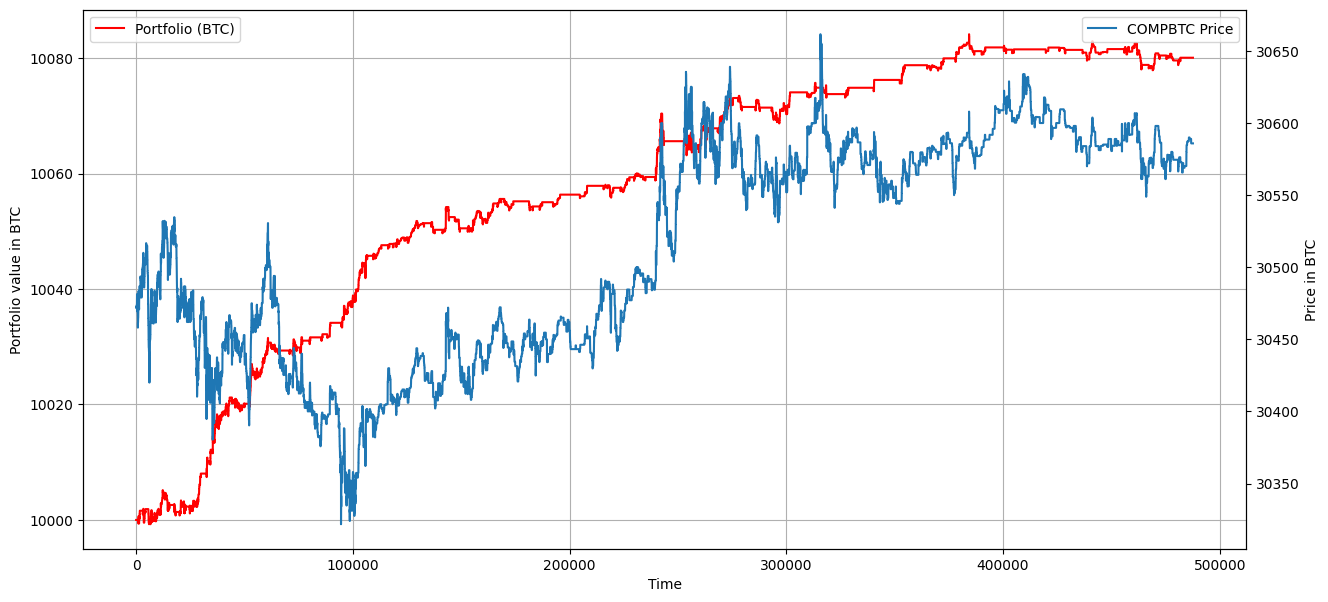

In [21]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')

ax.plot(balances.combined, label='Portfolio (BTC)', color='r')

ax2 = ax.twinx()
ax2.plot(balances.mid, label='COMPBTC Price')
ax.set_xlabel('Time')
ax2.set_ylabel('Price in BTC')
ax.set_ylabel('Portfolio value in BTC')
ax.legend(loc=2)
ax2.legend(loc=1)
ax.grid()

## PnL Analytics

In [47]:
df_t = pd.DataFrame(binance.trades)

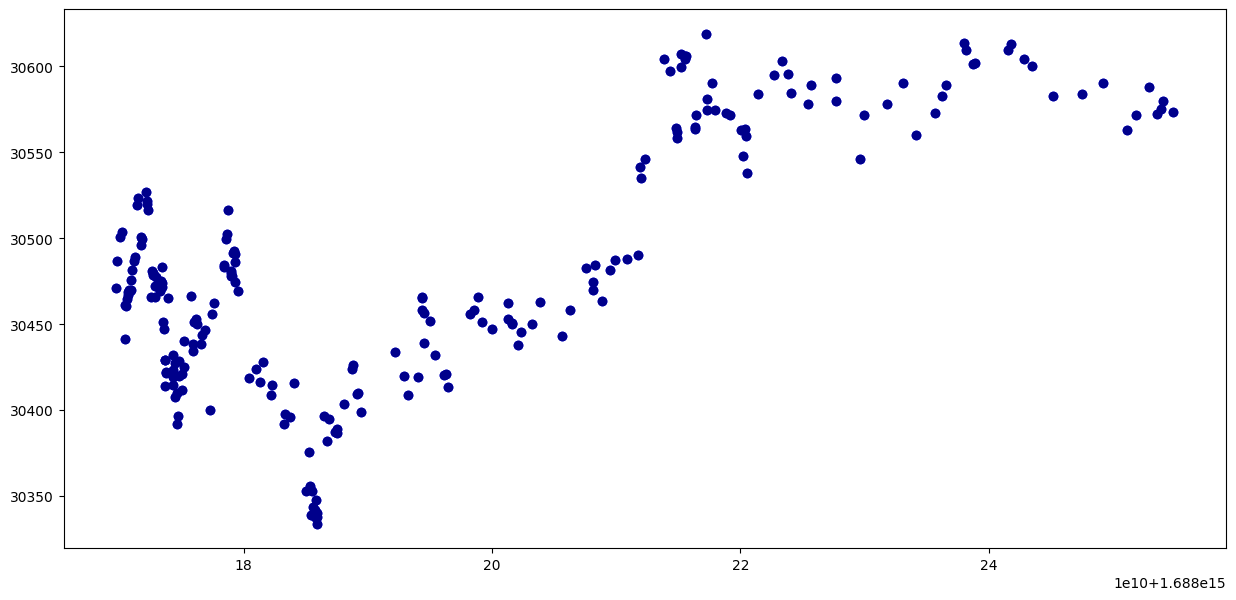

In [50]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')
ax.scatter(df_t.entryTime, df_t.price, color='blue', label='hedge trade')
ax.scatter(df_t.eventTime, df_t.price, color='darkblue', label='hedge trade')

In [ ]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')

ax.plot(balances.combined, label='Portfolio (BTC)', color='r')

ax2 = ax.twinx()
ax2.plot(balances.mid, label='COMPBTC Price')
ax.set_xlabel('Time')
ax2.set_ylabel('Price in BTC')
ax.set_ylabel('Portfolio value in BTC')
ax.legend(loc=2)
ax2.legend(loc=1)
ax.grid()